In [1]:
import cv2
import torch
import h5py
import numpy as np
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.generate_gui_code import *
from sketch2code.methods.lstm import *
from sketch2code.methods.baseline1_supervised import *
from s05_supervise_baseline import *
from s01_toy_img_feature import make_vocab as make_img_vocab

/local/minhpham/.local/share/virtualenvs/sketch2code-BAdGvpEG/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Purpose

Supervised for program synthesis

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#examples 1750


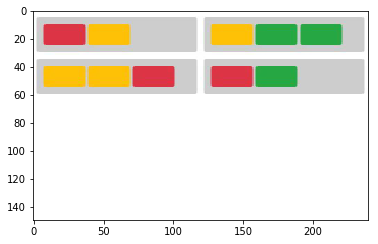

In [5]:
tags, images = load_dataset("toy")
print("#examples", len(tags))

def preprocess_img():
    global images
    return [shrink_img(img, 0.5).transpose((2, 0, 1)) for img in norm_rgb_imgs(images[:])]

images = cache_arrays("toy.shrink.imgs", preprocess_img)
plt.imshow(1 - images[0].transpose(1, 2, 0))
images = torch.tensor(images, device=device)

### Prepare datasets

In [24]:
nbtn_class2id, row_class2id = make_img_vocab(tags[:1250])
vocab, ivocab = make_toy_vocab()
img_vocabs = {"nbtn_classes": nbtn_class2id, "row_classes": row_class2id}
min_length = 10

def get_datasets():
    train_examples = make_dataset(tags[:1250], vocab, img_vocabs, min_length)
    valid_examples = make_dataset(tags[1250:1500], vocab, img_vocabs, min_length)
#     valid_examples = drop_examples(valid_examples, keep_prob=0.3)
    test_examples = make_dataset(tags[1500:], vocab, img_vocabs, min_length)

    return train_examples, valid_examples, test_examples

train_examples, valid_examples, test_examples = get_datasets()
# train_examples, valid_examples, test_examples = cache_arrays("s05.toy.datasets", get_datasets, pickle=True)

#examples 1250
#examples 250
#examples 250


### Define the model

In [25]:
class BLSuper2(nn.Module):
    
    def __init__(self, img_h: int, img_w: int, dsl_vocab: Dict[int, str], dsl_embedding_dim: int, dsl_hidden_dim: int):
        super().__init__()
        self.img_w = img_w
        self.img_h = img_h
        self.dsl_vocab = dsl_vocab
        self.dsl_hidden_dim = dsl_hidden_dim
        self.dsl_embedding_dim = dsl_embedding_dim

        self.__build_model()
    
    def __build_model(self):
        # network compute features of target image
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2)
        self.bn1 = nn.BatchNorm2d(16, momentum=0.9)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(32, momentum=0.9)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(64, momentum=0.9)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        imgsize = [self.img_h, self.img_w]
        for i, s in enumerate(imgsize):
            s = conv2d_size_out(s, 7, 2)
            s = pool2d_size_out(s, 3, 2)
            s = conv2d_size_out(s, 5, 1)
            s = pool2d_size_out(s, 3, 2)
            s = conv2d_size_out(s, 5, 1)
            s = pool2d_size_out(s, 3, 2)
            imgsize[i] = s
        
        linear_input_size = imgsize[0] * imgsize[1] * 64
        
        self.fc1 = nn.Linear(linear_input_size, 300)
        self.repr_size = 300
        
        # lstm that compute the context of the program
        self.word_embedding = nn.Embedding(
            num_embeddings=len(self.dsl_vocab), embedding_dim=self.dsl_embedding_dim, padding_idx=vocab['<pad>'])
        self.lstm = LSTMNoEmbedding(
            input_size=self.dsl_embedding_dim + self.repr_size,
            hidden_size=self.dsl_hidden_dim,
            n_layers=1)
        self.lstm2token = nn.Linear(self.dsl_hidden_dim, len(self.dsl_vocab))

    def forward(self, x1, x2, x2_lens):
        """
            @x1: desired images (batch: N x C x W x H)
            @x2: current programs (batch: N x T)
            @x2_lens: lengths of current programs (N)
        """
        batch_size = x2_lens.shape[0]
        
        # STEP 1: compute output from CNN
        # X is N x C x W x H
        x1 = self.pool1(F.selu(self.conv1(x1)))
        x1 = self.pool2(F.selu(self.conv2(x1)))
        x1 = self.pool3(F.selu(self.conv3(x1)))
        
        # flatten to N x (C * W * H)
        x1 = x1.view(batch_size, -1)
        x1 = F.relu(self.fc1(x1))
        
        # STEP 2: compute feature from lstm
        x2 = self.word_embedding(x2)
        x1 = x1.view(batch_size, 1, self.repr_size).expand(batch_size, x2.shape[1], x1.shape[1])
        x2 = torch.cat([x1, x2], dim=2)
        x2, (hn, cn) = self.lstm(x2, x2_lens, self.lstm.init_hidden(x2, batch_size))
        # flatten from N x T x H to N x (T * H)
        hn = hn.view(batch_size, -1)
        # flatten from N x T x H to (N * T) x H
        x2 = x2.contiguous().view(-1, self.dsl_hidden_dim)
        nts = F.log_softmax(self.lstm2token(x2), dim=1)
        return nts        

In [26]:
model = BLSuper2(img_h=150, img_w=240, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=200).to(device)
print(model.train())

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

histories = train(model, scheduler, optimizer, images, (train_examples, valid_examples, test_examples), n_epoches=100, batch_size=100, device=device)

BLSuper2(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=300, bias=True)
  (word_embedding): Embedding(15, 100, padding_idx=0)
  (lstm): LSTMNoEmbedding(
    (lstm): LSTM(400, 200, batch_first=True)
  )
  (lstm2token): Linear(in_features=200, out_features=15, bias=True)
)


In [27]:
next_token_func = wrap_next_token_func(lambda bimgs, bx, bxlen: model(bimgs, bx, bxlen))
results = beam_search(images[0], vocab, next_token_func, 3, device=device)

for program, prob in results:
    print('>>>', prob, program)
    for token in program:
        print(ivocab[token])

[autoreload of sketch2code.generate_gui_code failed: Traceback (most recent call last):
  File "/local/minhpham/.local/share/virtualenvs/sketch2code-BAdGvpEG/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/local/minhpham/.local/share/virtualenvs/sketch2code-BAdGvpEG/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/local/minhpham/.local/share/virtualenvs/sketch2code-BAdGvpEG/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/minhpham/.local/share/virtualenvs/sketch2code-BAdGvpEG/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<froz

>>> 2.153255751396786e-36 [1, 10, 10, 3, 4, 9, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 12, 14, 12, 14, 11, 14, 11, 14, 11, 14, 12, 14, 12, 14, 12, 14, 11, 14, 12, 14, 12, 14, 11, 14, 11, 14, 11, 14, 11, 14, 12, 14, 12, 14, 12, 14, 11, 14, 12, 14, 11, 14, 12, 14, 12, 14, 12, 14, 12, 14, 12, 14, 12, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 11, 14, 12, 14, 11, 14, 12, 14, 11, 14, 11, 14, 11, 14, 11, 14, 12]
<begin>
</div>
</div>
<div class="row">
<div class="col-12">
<div class="grey-background">
<button class="btn btn-danger">
</button>
<button class="btn btn-danger">
</button>
<button class="btn btn-danger">
</button>
<button class="btn btn-danger">
</button>
<button class="btn btn-danger">
</button>
<button class="btn btn-danger">
</button>
<button class="btn btn-danger">
</button>
<button class="btn btn-warning">
</button>
<button class="btn btn-warning">
</button>
<button class="btn btn-danger">
</button>
<button class="btn btn-danger">
</button>
<button class="btn

In [23]:
[ivocab[i] for i in train_examples[0].context_tokens]

['<begin>',
 '<div class="container-fluid">',
 '<div class="row">',
 '<div class="col-4">',
 '<div class="grey-background">',
 '<button class="btn btn-success">',
 '</button>',
 '<button class="btn btn-success">',
 '</button>',
 '</div>',
 '</div>',
 '<div class="col-4">',
 '<div class="grey-background">',
 '<button class="btn btn-success">',
 '</button>',
 '<button class="btn btn-danger">',
 '</button>',
 '</div>',
 '</div>',
 '<div class="col-4">',
 '<div class="grey-background">',
 '<button class="btn btn-danger">',
 '</button>',
 '</div>',
 '</div>',
 '</div>',
 '</div>']

In [22]:
ivocab

{0: '<pad>',
 1: '<begin>',
 2: '<end>',
 3: '<div class="row">',
 4: '<div class="col-12">',
 5: '<div class="col-6">',
 6: '<div class="col-4">',
 7: '<div class="col-3">',
 8: '<div class="container-fluid">',
 9: '<div class="grey-background">',
 10: '</div>',
 11: '<button class="btn btn-danger">',
 12: '<button class="btn btn-warning">',
 13: '<button class="btn btn-success">',
 14: '</button>'}